In [1]:
import numpy as np 
import pandas as pd 
import time

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4505163896987290349
]


In [3]:
df = pd.read_csv(r'Twitter_Training_Data/Sentiment Analysis Dataset.csv', usecols=['Sentiment','SentimentText'])

In [4]:
df['SentimentText'] = df['SentimentText'].apply(lambda x: x.lower())
df['SentimentText'] = df['SentimentText'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [5]:
print(df[ df['Sentiment'] == 0].size)
print(df[ df['Sentiment'] == 0].size)

for idx,row in df.iterrows():
    row[1] = row[1].replace('rt',' ')
    
max_fatures = 20000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['SentimentText'].values)
X = tokenizer.texts_to_sequences(df['SentimentText'].values)
X = pad_sequences(X)

1576872
1576872


In [6]:
df.head()

,Sentiment,SentimentText
0,0,is so sad for my apl friend
1,0,i missed the new moon trailer
2,1,omg its already 730 o
3,0,omgaga im sooo im gunna cry ive be...
4,0,i think mi bf is cheating on me ...


In [7]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 98, 128)           2560000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 98, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 2,815,194
Trainable params: 2,815,194
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
import json
dictionary = tokenizer.word_index
with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

In [9]:
Y = pd.get_dummies(df['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1057671, 98) (1057671, 2)
(520943, 98) (520943, 2)


In [10]:
x_val = X_train[:211534]
partial_x_train = X_train[211534:]

y_val = Y_train[:211534]
partial_y_train = Y_train[211534:]

In [11]:
with tf.device('/cpu:0'):
    t0 = time.time()
    history = model.fit(partial_x_train, partial_y_train, epochs=13, batch_size=512, validation_data=(x_val, y_val))
    t1 = time.time()
    total_time = t1 - t0
    print("Task took " + repr(total_time))

Train on 846137 samples, validate on 211534 samples
Epoch 1/13
846137/846137 [==============================] - 2283s 3ms/step - loss: 0.4484 - acc: 0.7899 - val_loss: 0.4119 - val_acc: 0.8105
Epoch 2/13
846137/846137 [==============================] - 2284s 3ms/step - loss: 0.4025 - acc: 0.8163 - val_loss: 0.4022 - val_acc: 0.8168
Epoch 3/13
846137/846137 [==============================] - 2280s 3ms/step - loss: 0.3872 - acc: 0.8243 - val_loss: 0.4005 - val_acc: 0.8175
Epoch 4/13
846137/846137 [==============================] - 2278s 3ms/step - loss: 0.3754 - acc: 0.8306 - val_loss: 0.4045 - val_acc: 0.8161
Epoch 5/13
846137/846137 [==============================] - 2277s 3ms/step - loss: 0.3648 - acc: 0.8362 - val_loss: 0.4005 - val_acc: 0.8185
Epoch 6/13
846137/846137 [==============================] - 2275s 3ms/step - loss: 0.3552 - acc: 0.8414 - val_loss: 0.4068 - val_acc: 0.8186
Epoch 7/13
846137/846137 [==============================] - 2274s 3ms/step - loss: 0.3457 - acc: 0.845

In [12]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

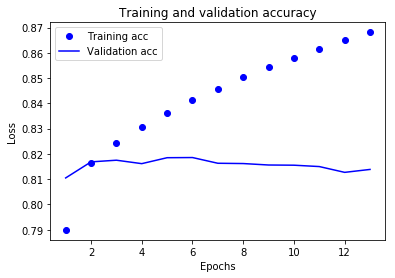

In [13]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
validation_size = 104188

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 512)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.46
acc: 0.81


In [15]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 81.5200646999923 %
neg_acc 81.76668707899572 %


In [16]:
model_json = model.to_json()
with open('Twitter_SA_Model.json', 'w') as json_file:
    json_file.write(model_json)

model.save('Twitter_SA_Model.h5')